In [1]:
import sys
sys.path.append('src/')
import numpy as np
import torch, torch.nn
from library_function import library_1D
from neural_net import LinNetwork
from DeepMod import *
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
import torch.nn as nn
from torch.autograd import grad
from scipy.io import loadmat
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2

# Preparing data

In [2]:
rawdata =  loadmat('data/KS.mat')
t = rawdata['tt']
x=rawdata['x']
uu=rawdata['uu']
uu.size

103113

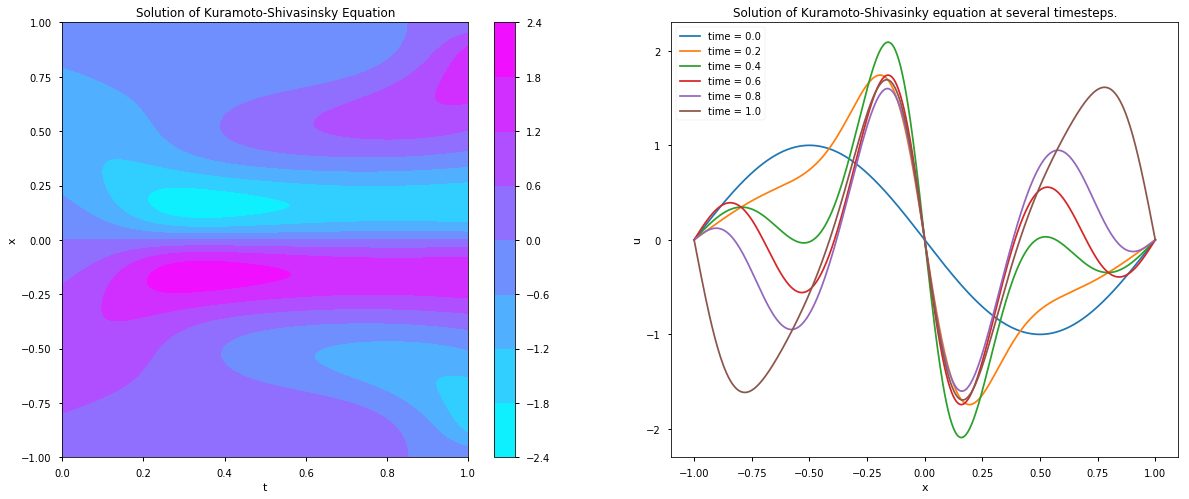

In [3]:
x_grid,t_grid = np.meshgrid(x,t,indexing='ij')

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.contourf(t_grid,x_grid,uu,cmap='cool')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Solution of Kuramoto-Shivasinsky Equation')
plt.colorbar()

plt.subplot(122)
for time in np.arange(0, np.shape(uu)[1], 40):
    plt.plot(np.transpose(x), uu[:, time], label='time = %.1f'%t[0,time])
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.title('Solution of Kuramoto-Shivasinky equation at several timesteps.')
plt.show()

In [5]:
X = np.transpose((x_grid.flatten(), t_grid.flatten()))
y = uu.reshape((uu.size, 1))

In [8]:
number_of_samples = 1000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32)

In [9]:
y_train.shape

torch.Size([1000, 1])

# Building network

In [28]:
optim_config ={'type':mse, 'lambda':1e-8,'max_iteration':2000}
lib_config={'lib_type':library_1D,'poly_order':1, 'diff_order':4, 'total_terms':10}
network_config={'input_dim':2, 'hidden_dim':20, 'layers':6, 'output_dim':2}

# MSE Run

In [29]:
init_coeff = torch.tensor([0.2,0,0,0,0,0,0,0,0,0], dtype=torch.float32, requires_grad=True)

In [30]:
y_t,theta, weight_vector = DeepMod_single(X_train, y_train, network_config, library_1D, lib_config, optim_config,network,init_coeff)

Epoch | Total loss | MSE | PI | L1 
0 1.0E+00 8.3E-01 2.0E-01 2.0E-10
[ 0.2  0.   0.  -0.   0.  -0.   0.   0.  -0.   0. ]
1000 7.4E-01 7.4E-01 5.7E-04 2.3E-10
[ 0.09 -0.    0.01 -0.   -0.   -0.11 -0.    0.01 -0.   -0.  ]


In [31]:
xlist=np.squeeze(X_train.detach().numpy()[:,0])
tlist= np.squeeze(X_train.detach().numpy()[:,1])
ylist= np.squeeze(prediction.detach().numpy()[:,0])

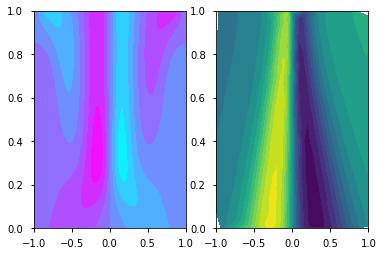

In [32]:
f, ax = plt.subplots(1,2)
ax[0].contourf(x_grid,t_grid,uu,cmap='cool')
ax[1].tricontourf(xlist,tlist,ylist, 20) # choose 20 contour levels, just to show how good its interpolation is

In [17]:
prediction, network, y_t,theta  = DeepMod_mse(X_train, y_train, network_config, library_1D, lib_config, optim_config)

Epoch | Total loss | MSE 
0 7.8E-01 7.8E-01


# Least square fit 

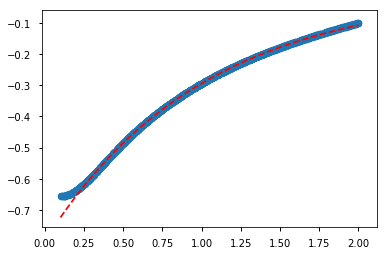

In [10]:
plt.plot(X,np.gradient(y[:,0])/0.001,'r--')
plt.scatter(X_train.detach().numpy()[:,0], y_t.detach().numpy()[:,0])

In [46]:
def func(X, a, b, c, d):
    x1,x2 = X
    return a + b*x1 + c*x2 + d*x1*x2 

def func_new(X, a, b, c, d, e, f):
    x1,x2,x4,x5 = X
    return a + b*x1 + c*x2 + d*x1*x2 + e*x4 + f*x5

def func_simple(X, a, b, c):
    x1,x2 = X
    return a + b*x1 + c*x2

In [48]:
theta1 = np.squeeze(prediction[:,0].detach().numpy())
theta2 = np.squeeze(prediction[:,1].detach().numpy())
theta4 = np.squeeze(theta[:,4].detach().numpy())
theta5 = np.squeeze(theta[:,5].detach().numpy())

In [52]:
prediction[:,0].shape

torch.Size([1000])

In [ ]:
x1 = np.squeeze(prediction[:,0].detach().numpy())
x2 = np.squeeze(prediction[:,1].detach().numpy())
z1 = y_t.detach().numpy()[:,0]
z2 = y_t.detach().numpy()[:,1]

AttributeError: 'tuple' object has no attribute 'shape'

In [54]:
# initial guesses for a,b,c:
p0 = 0., 0., 0., 0., 0., 0.
w1 = curve_fit(func_new, (theta1,theta2, theta4, theta5), z1, p0)[0]
w2 = curve_fit(func_new, (theta1,theta2, theta4, theta5), z2, p0)[0]

In [13]:
z1_ref = np.gradient(np.squeeze(prediction[:,0].detach().numpy()),np.squeeze(X_train.detach().numpy()))
z2_ref = np.gradient(np.squeeze(prediction[:,1].detach().numpy()),np.squeeze(X_train.detach().numpy()))

In [15]:
x1 = y[:,0]
x2 = y[:,1]
z1 = np.gradient(y[:,0],np.squeeze(X))
z2 = np.gradient(y[:,1],np.squeeze(X))

In [55]:
init_coeff=torch.tensor(np.transpose(np.array((w1,w2))), dtype=torch.float32, requires_grad=True)

In [56]:
print(init_coeff)

tensor([[ 0.1871, -0.4730],
        [-0.5034,  0.6698],
        [-0.3493,  0.4551],
        [ 0.3650, -0.4874],
        [-0.0250,  0.0320],
        [ 0.0603, -0.0732]], requires_grad=True)


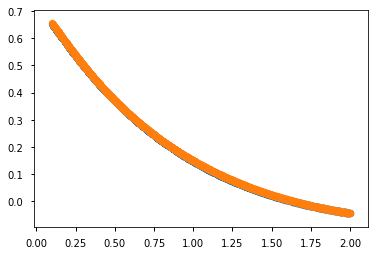

In [33]:
plt.scatter(X_train.detach().numpy(),w2[0]+w2[1]*x1+w2[2]*x2+w2[3]*x1*x2)
plt.scatter(X_train.detach().numpy(),x1-0.25*x2)

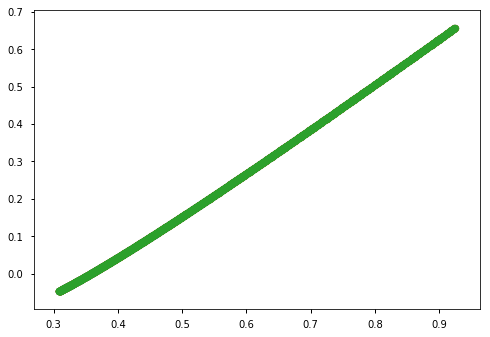

In [578]:
plt.scatter(x1,z2)
plt.scatter(x1,w2[0]+w2[1]*x1+w2[2]*x2+w2[3]*x1*x2)
plt.scatter(x1,x1-0.25*x2)

In [74]:
y_t,theta, weight_vector = DeepMod_pretrained_nomse(X_train, y_train, network_config, library_1D, lib_config, optim_config,network,init_coeff)

Epoch | Total loss | MSE | PI | L1 
0 2.9E+01 6.2E-04 2.9E+01 2.0E-07
[ 0.2  0.  -0.   0.   0.  -0.   0.  -0.   0.   0. ]
1000 2.9E+01 6.2E-04 2.9E+01 2.0E-07
[ 0.16  0.    0.    0.    0.   -0.04  0.    0.    0.    0.  ]
2000 2.9E+01 6.2E-04 2.9E+01 2.0E-07
[ 0.15  0.    0.    0.    0.   -0.05  0.    0.    0.    0.  ]
3000 7.5E+02 6.2E-04 7.5E+02 2.0E-07
[ 0.15 -0.    0.    0.   -0.   -0.05 -0.    0.    0.   -0.  ]
4000 2.9E+01 6.2E-04 2.9E+01 2.0E-07
[ 0.15  0.    0.    0.    0.   -0.05  0.    0.    0.    0.  ]
5000 2.9E+01 6.2E-04 2.9E+01 2.0E-07
[ 0.15 -0.    0.    0.   -0.   -0.05 -0.    0.    0.   -0.  ]
6000 2.9E+01 6.2E-04 2.9E+01 2.0E-07
[ 0.15  0.   -0.   -0.    0.   -0.05  0.   -0.   -0.    0.  ]
7000 1.2E+03 6.2E-04 1.2E+03 2.0E-07
[ 0.15 -0.    0.    0.   -0.   -0.05 -0.    0.    0.   -0.  ]


KeyboardInterrupt: 

In [62]:
y_t,theta, weight_vector = DeepMod_single(X_train, y_train, network_config, library_1D, lib_config, optim_config,network,init_coeff)

Epoch | Total loss | MSE | PI | L1 
0 2.8E+01 1.0E-03 2.8E+01 2.0E-07
[ 0.2  0.   0.  -0.  -0.  -0.   0.   0.  -0.  -0. ]
1000 3.5E+00 9.5E-01 2.6E+00 1.1E-06
[-0.32  0.14 -0.    0.    0.01 -0.52  0.14 -0.    0.    0.01]
2000 1.7E+00 8.7E-01 7.9E-01 9.1E-07
[-0.2   0.14 -0.    0.    0.01 -0.4   0.14 -0.    0.    0.01]
3000 1.2E+00 8.5E-01 3.4E-01 7.8E-07
[-0.13  0.15 -0.    0.    0.01 -0.33  0.15 -0.    0.    0.01]
4000 1.0E+00 8.4E-01 1.7E-01 6.9E-07
[-0.08  0.16 -0.    0.    0.01 -0.28  0.16 -0.    0.    0.01]


KeyboardInterrupt: 

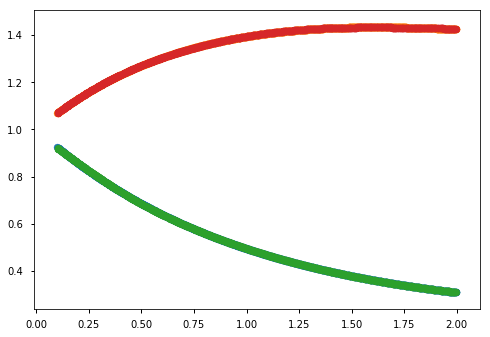

In [347]:
plt.scatter(X[:,0],y[:,0])
plt.scatter(X[:,0],y[:,1])
plt.scatter(X_train.detach().numpy(),prediction.detach().numpy()[:,0])
plt.scatter(X_train.detach().numpy(),prediction.detach().numpy()[:,1])
plt.show()

In [211]:
from scipy.optimize import curve_fit

In [207]:
def func(X, a, b, c, d):
    x1,x2 = X
    return a + b*x1 + c*x2 + d*x1*x2

In [234]:
x1 = y[:,0]
x2 = y[:,1]
z1 = np.gradient(y[:,0],np.squeeze(X))
z2 = np.gradient(y[:,1],np.squeeze(X))

In [235]:
# initial guesses for a,b,c:
p0 = 0., 0., 0., 0.0
curve_fit(func, (x1,x2), z1, p0)[0]

array([ 1.61212549e-04, -2.50109150e-01,  9.99827395e-01,  1.10820518e-04])

In [108]:
sparse_weight_vector, sparsity_pattern, prediction, network = DeepMod(X_train, y_train,network_config, lib_config, optim_config)

Epoch | Total loss | MSE | PI | L1 
0 2.4E+00 9.0E-01 1.5E+00 1.0E-06
[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]


KeyboardInterrupt: 

In [202]:
testlib = np.array([y[:,0],y[:,1],y[:,0]*y[:,1]])

In [187]:
X.shape

(1900, 1)

In [188]:
def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    results = sm.OLS(y, X).fit()
    return results

In [205]:
print(reg_m(np.gradient(y[:,0]), x).summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.376e+11
Date:                Sun, 09 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:00:25   Log-Likelihood:                 32269.
No. Observations:                1900   AIC:                        -6.453e+04
Df Residuals:                    1896   BIC:                        -6.451e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           1.11e-07   3.02e-08      3.672      0.0

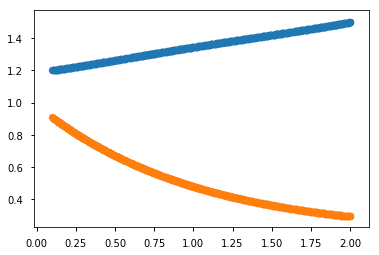

In [78]:
plt.scatter(X_train.detach().numpy(),prediction.detach().numpy()[:,0])
plt.scatter(X_train.detach().numpy(),prediction.detach().numpy()[:,1])

In [ ]:
prediction = network(torch.tensor(X, dtype=torch.float32))

In [15]:
prediction = prediction.detach().numpy()

In [64]:
x, y = np.meshgrid(X[:,0], X[:,1])

In [145]:
mask = torch.tensor((0,1,3))

In [157]:
mask

tensor([0, 1, 3])

In [158]:
sparse_coefs = torch.tensor((0.1,0.2,0.4)).reshape(-1,1)

In [159]:
sparse_coefs

tensor([[0.1000],
        [0.2000],
        [0.4000]])

In [291]:
dummy = torch.ones((5,3,1))
dummy2 = torch.ones((5,1,4))

In [292]:
(dummy @ dummy2).shape

torch.Size([5, 3, 4])

In [293]:
dummy.shape

torch.Size([5, 3, 1])

In [294]:
dummy.reshape(-1,3,1).shape

torch.Size([5, 3, 1])

In [164]:
dummy = dummy.reshape(2,2)

In [128]:
torch.where(coefs(mask),coefs,dummy)

TypeError: 'Tensor' object is not callable

In [45]:
x = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, x)
Z = np.sin(X)*np.sin(Y)


In [30]:
b = torch.ones((10, 2), dtype=torch.float32, requires_grad=True)

In [31]:
a = torch.tensor(np.ones((2,10)), dtype=torch.float32)

In [13]:
test=torch.tensor([[0.3073, 0.4409],
        [0.0212, 0.6602]])

In [17]:
torch.where(test>torch.tensor(0.3),test, torch.zeros_like(test))

tensor([[0.3073, 0.4409],
        [0.0000, 0.6602]])

In [83]:
test2[0,:].reshape(-1,1)

tensor([[0.3073],
        [0.4409],
        [0.0212],
        [0.6602]])

In [47]:
mask=torch.nonzero(test2[0,:])

In [39]:
mask=torch.reshape(torch.nonzero(test2), (1,4))

RuntimeError: shape '[1, 4]' is invalid for input of size 8

In [48]:
mask

tensor([[0],
        [1],
        [2],
        [3]])

In [54]:
test2[mask[1]]

RuntimeError: index 1 is out of bounds for dim with size 1

In [49]:
a.shape[1]

10